# DL-модель для классификации состояния дерева (Good/Fair/Poor) по данным из NY 2015 Street Tree Census.

## Импорт библиотек

In [1]:
import os
import zipfile
import requests
import pandas as pd
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns


## Dowload dataset 2015 Street Tree Census - Tree Data

Описание датасета https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh/about_data

In [2]:
# Путь к директории с исходными данными 
path_raw = os.path.expanduser("../data/raw")
# URL для загрузки датасета
url = "https://www.kaggle.com/api/v1/datasets/download/new-york-city/ny-2015-street-tree-census-tree-data"

name_dataset = "2015-street-tree-census-tree-data" 
output_path = os.path.expanduser(f"{path_raw}/{name_dataset}.zip")


In [3]:
def download_file(url, output_path):
    """ 
    Загрузка файла по URL и сохранение в output_path
    """
    # Проверка наличия архива
    if not os.path.exists(output_path):
        # Загрузка файла
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                    f.write(chunk)
            print(f"Файл загружен: {output_path}")
        else:
            print(f"Ошибка при загрузке файла: {response.status_code}")
    else:
        print(f"Файл уже существует: {output_path}")

    # Распаковка архива
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall(path_raw)
        print("Файлы распакованы")

download_file(url, output_path)

Файл уже существует: ../data/raw/2015-street-tree-census-tree-data.zip


Файлы распакованы


In [4]:
df = pd.read_csv(f'{path_raw}/{name_dataset}.csv')
df.head(3)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09


## Анализ данных

In [5]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community_board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council_district',
       'census_tract', 'bin', 'bbl'],
      dtype='object')

In [6]:
# Распределение таргета
print(df[['status', 'health']].value_counts())
print(df[df['status'] != 'Alive']['status'].value_counts())
print(df[df['status'] != 'Alive']['health'].value_counts())
# Только у живых деревьев есть health status
df = df[df['status'] == 'Alive']
# Удалим строки с пропущенными значениями в health - это наш таргет
df.dropna(subset=['health'], inplace=True)  

df.shape

status  health
Alive   Good      528850
        Fair       96504
        Poor       26818
Name: count, dtype: int64
status
Stump    17654
Dead     13961
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


(652172, 45)

In [7]:
# По описанию датасета, в нем содержится информация о деревьях в Нью-Йорке
# Найдем количество деревьев в каждом районе
df.borough.value_counts()

borough
Queens           237974
Brooklyn         169744
Staten Island    101442
Bronx             80585
Manhattan         62427
Name: count, dtype: int64

In [8]:
df.steward.value_counts().sort_values(ascending=False).head(10)

steward
1or2       143557
3or4        19183
4orMore      1610
Name: count, dtype: int64

In [9]:
df.state.value_counts().sort_values(ascending=False).head(10)

state
New York    652172
Name: count, dtype: int64

In [10]:
df.stump_diam.value_counts().sort_values(ascending=False).head(10)

stump_diam
0    652172
Name: count, dtype: int64

In [11]:
df.nta_name.value_counts().sort_values(ascending=False).head(10)

nta_name
Annadale-Huguenot-Prince's Bay-Eltingville        12530
Great Kills                                       10267
Bayside-Bayside Hills                              9386
East New York                                      9188
Rossville-Woodrow                                  8842
New Springville-Bloomfield-Travis                  8142
Charleston-Richmond Valley-Tottenville             7913
Forest Hills                                       7330
Whitestone                                         7253
Georgetown-Marine Park-Bergen Beach-Mill Basin     7221
Name: count, dtype: int64

In [12]:
print(
    "Максимальное количество уникальных названий вида дерева",
    "на латыне для каждого обывательского названия:",
    df.groupby("spc_common").spc_latin.nunique().max(),
)

print(
    "Максимальное количество уникальных обывательских названий",
    "вида дерева для каждого названия на латыне:",
    df.groupby("spc_latin").spc_common.nunique().max(),
)

Максимальное количество уникальных названий вида дерева на латыне для каждого обывательского названия: 1
Максимальное количество уникальных обывательских названий вида дерева для каждого названия на латыне: 1


In [13]:
def plot_corr_matrix(df, method='pearson', figsize=(10, 10)):
    """
    Построение матрицы корреляции
    """
    corr = df.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
    plt.show()

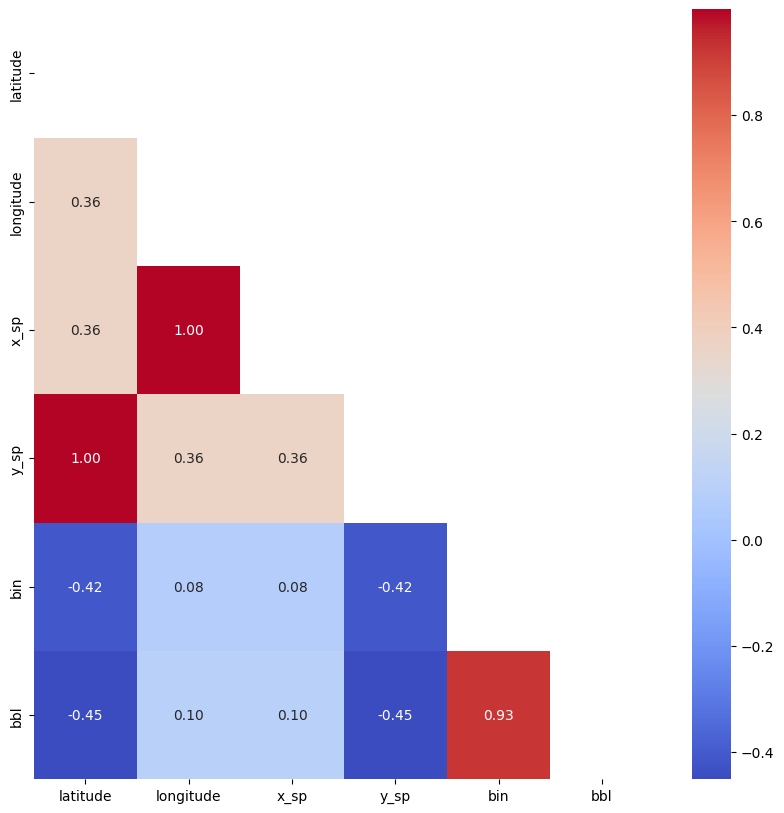

In [14]:
plot_corr_matrix(
    df[
        [
            "latitude",
            "longitude",
            "x_sp",
            "y_sp",
            "bin",
            "bbl",
        ]
    ],
    method="kendall",
)

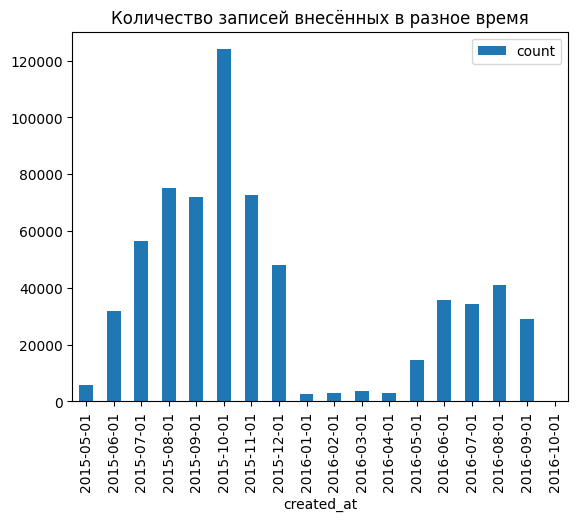

In [15]:
df.assign(created_at=lambda row: pd.to_datetime(row.created_at)) \
    .loc[:, ["created_at", "tree_id"]] \
    .resample("MS", on="created_at") \
    .count() \
    .rename(columns={"tree_id": "count"}) \
    .reset_index() \
    .assign(created_at=lambda row: row.created_at.dt.date) \
    .plot(
        kind="bar",
        x="created_at",
        y="count",
        title="Количество записей внесённых в разное время",
    ).get_figure().show()

plt.show()

Для задачи классификации состояния дерева (Good/Fair/Poor) некоторые столбцы могут быть не нужны,   
так как они не влияют на состояние дерева или являются избыточными.   
 Вот список столбцов, которые можно исключить:  
 -  status - все деревья живые, так как только у них есть значения healt(target) у мертвых и пенков нет
 -  state - все значения одинаковые ("New York")
 -  tree_id - уникальный идентификатор дерева
 -  created_at - дата создания записи. В течении года были записи
 -  stump_diam - диаметр пня. Все деревья живые, поэтому пень не имеет значения для состояния дерева и он везде ноль.
 -  borocode: Код района, не влияет на состояние. есть отдельный столбец borough
 -  x_sp: Координата X, коррелирует с longitude
 -  y_sp: Координата Y, коррелирует с latitude
 -  nta_name: есть отдельный столбец nta 
 -  council_district: район совета, не влияет на состояние
 -  census_tract: номер участка, не влияет на состояние
 -  bin и bbl коррелируют между собой поэтому можно удалить один из них
 -  nta_name - район, не влияет на состояние
 -  zip_city - код города
 -  spc_common - обывательское название. убираем т.к. везде есть латинское название



In [16]:
df_drop_columns = ['status', 'state', 'tree_id', 'created_at', 'stump_diam', 'address', 'spc_common',
                   'borocode', 'x_sp', 'y_sp', 'council_district', 'census_tract', 'nta_name',
                   'bin', 'zip_city']
df = df.drop(columns=df_drop_columns)
df.shape


(652172, 30)

In [17]:
df.isna().sum().sort_values(ascending=False).head(10)

guards       572306
steward      487822
problems     426328
bbl            9103
spc_latin         5
sidewalk          1
curb_loc          0
health            0
block_id          0
user_type         0
dtype: int64

array([[<Axes: title={'center': 'block_id'}>,
        <Axes: title={'center': 'tree_dbh'}>,
        <Axes: title={'center': 'postcode'}>],
       [<Axes: title={'center': 'community_board'}>,
        <Axes: title={'center': 'cncldist'}>,
        <Axes: title={'center': 'st_assem'}>],
       [<Axes: title={'center': 'st_senate'}>,
        <Axes: title={'center': 'boro_ct'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'bbl'}>, <Axes: >]], dtype=object)

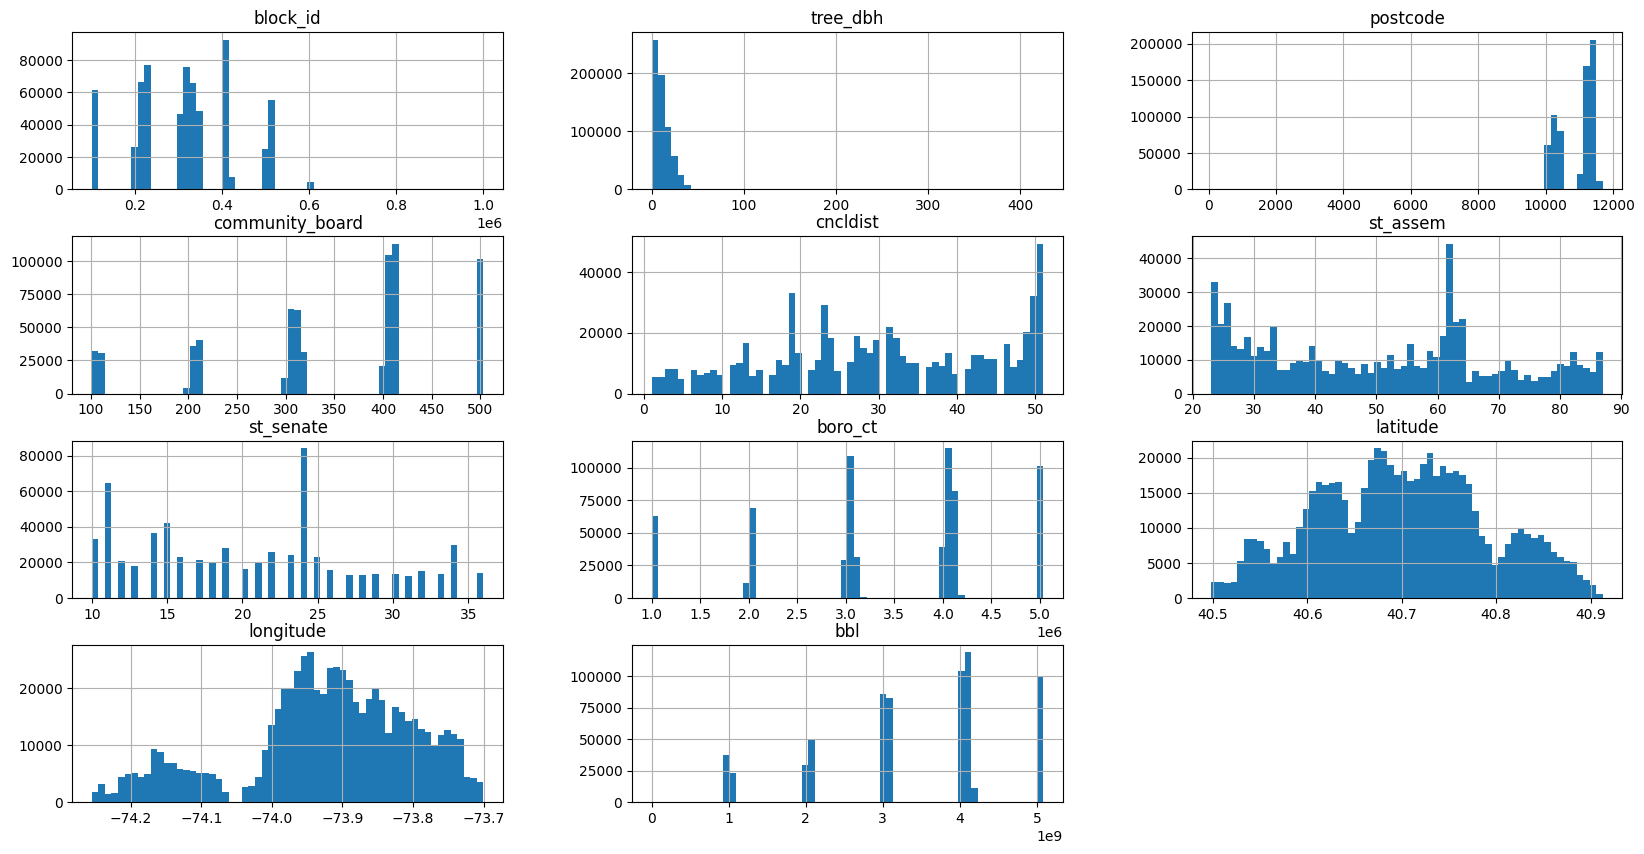

In [18]:
df.hist(bins=60, figsize=(20,10))


## Преоброзование данных

In [19]:
def df_fillna(df):
    df['spc_latin'].fillna('No observation',inplace=True)
    df['sidewalk'].fillna('NoDamage',inplace=True)
    df['problems'].fillna('NoProblem',inplace=True)
    df['steward'].fillna('None',inplace=True)
    df['guards'].fillna('None',inplace=True)
    df['bbl'].fillna('No observation',inplace=True)
    return df
df = df_fillna(df)
df.isna().sum().sort_values(ascending=False).head(10)



/tmp/ipykernel_75410/3135792782.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['spc_latin'].fillna('No observation',inplace=True)
/tmp/ipykernel_75410/3135792782.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

block_id     0
tree_dbh     0
curb_loc     0
health       0
spc_latin    0
steward      0
guards       0
sidewalk     0
user_type    0
problems     0
dtype: int64

In [21]:
# В колонке problems содержится информация о проблемах с деревьями
# Разделим их на отдельные колонки
df.problems.value_counts()

problems
NoProblem                                                                       426328
Stones                                                                           95673
BranchLights                                                                     29452
Stones,BranchLights                                                              17808
RootOther                                                                        11418
                                                                                 ...  
Stones,MetalGrates,WiresRope,TrunkLights,TrunkOther,BranchLights,BranchOther         1
WiresRope,BranchLights,Sneakers                                                      1
MetalGrates,WiresRope,TrunkLights                                                    1
Stones,RootOther,TrunkLights,TrunkOther,BranchOther                                  1
MetalGrates,TrunkOther,Sneakers                                                      1
Name: count, Length: 232, dtype: i

In [23]:
# Разделение строки с проблемами на отдельные проблемы
df['problems_new'] = df['problems'].str.split(', ')
df.problems_new.value_counts()

problems_new
[NoProblem]                                                                       426328
[Stones]                                                                           95673
[BranchLights]                                                                     29452
[Stones,BranchLights]                                                              17808
[RootOther]                                                                        11418
                                                                                   ...  
[Stones,MetalGrates,WiresRope,TrunkLights,TrunkOther,BranchLights,BranchOther]         1
[WiresRope,BranchLights,Sneakers]                                                      1
[MetalGrates,WiresRope,TrunkLights]                                                    1
[Stones,RootOther,TrunkLights,TrunkOther,BranchOther]                                  1
[MetalGrates,TrunkOther,Sneakers]                                                      1
Name: co

In [34]:
# Разделение строки с проблемами на отдельные проблемы
df['problems'] = df['problems'].str.split(',')

In [35]:
df['problems'].value_counts()

Series([], Name: count, dtype: int64)

## Расмотрим корреляцию

In [20]:
def convert_categorical_to_numeric(df, categorical_columns):
    """
    Преобразует категориальные и текстовые признаки в числовые с использованием one-hot encoding.
    """
    df_numeric = pd.get_dummies(df, columns=categorical_columns)
    return df_numeric

def cramers_v(x, y):
    """
    Вычисляет корреляцию Крамера V между двумя категориальными признаками.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = pg.chi2_independence(confusion_matrix).loc[0, 'chi2']
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def calculate_correlations(df, categorical_columns):
    """
    Вычисляет корреляции между числовыми признаками с использованием метода Спирмена
    и между категориальными признаками с использованием метода Крамера V.
    """
    # Преобразование категориальных признаков в числовые
    df_numeric = convert_categorical_to_numeric(df, categorical_columns)
    
    # Вычисление корреляции между числовыми признаками с использованием метода Спирмена
    corr_spearman = df_numeric.corr(method='spearman')
    
    # Вычисление корреляции между категориальными признаками с использованием метода Крамера V
    categorical_corr = {}
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 != col2:
                categorical_corr[(col1, col2)] = cramers_v(df[col1], df[col2])
    
    return corr_spearman, categorical_corr



In [29]:
df.problems.value_counts()

problems
NoProblem                                                                       426328
Stones                                                                           95673
BranchLights                                                                     29452
Stones,BranchLights                                                              17808
RootOther                                                                        11418
                                                                                 ...  
Stones,MetalGrates,WiresRope,TrunkLights,TrunkOther,BranchLights,BranchOther         1
WiresRope,BranchLights,Sneakers                                                      1
MetalGrates,WiresRope,TrunkLights                                                    1
Stones,RootOther,TrunkLights,TrunkOther,BranchOther                                  1
MetalGrates,TrunkOther,Sneakers                                                      1
Name: count, Length: 232, dtype: i

In [21]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns

['curb_loc',
 'health',
 'spc_latin',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'problems',
 'root_stone',
 'root_grate',
 'root_other',
 'trunk_wire',
 'trnk_light',
 'trnk_other',
 'brch_light',
 'brch_shoe',
 'brch_other',
 'borough',
 'nta',
 'bbl']